# 🚀 LangGraph QuickStart 튜토리얼

## 📚 개요

이 튜토리얼은 LangGraph의 핵심 개념과 기능을 단계별로 학습하는 종합 가이드입니다. 기본 챗봇 구축부터 시작하여 도구 통합, 메모리 관리, Human-in-the-Loop, 상태 커스터마이징, 타임 트래블까지 LangGraph의 강력한 기능들을 체계적으로 익힐 수 있습니다.

## 🎯 학습 목표

1. **기본 챗봇 구축**: StateGraph를 사용한 기본적인 대화형 AI 구현
2. **도구 통합**: 외부 API와 도구를 활용한 챗봇 기능 확장
3. **메모리 관리**: 체크포인팅을 통한 대화 상태 유지
4. **Human-in-the-Loop**: 인간 개입이 필요한 워크플로우 구현
5. **상태 커스터마이징**: 복잡한 비즈니스 로직을 위한 상태 확장
6. **타임 트래블**: 이전 상태로 되돌아가기 및 대체 경로 탐색

## 🔑 주요 개념

- **StateGraph**: 상태 기계로 챗봇 구조를 정의
- **Node**: 작업 단위 (함수)
- **Edge**: 노드 간 전환
- **State**: 그래프 전체에서 공유되는 데이터
- **Checkpointing**: 상태 저장 및 복원
- **Tool**: 외부 기능 통합
- **Human-in-the-Loop**: 인간 검토/승인 프로세스

## 📋 사전 준비사항

- Python 3.11 이상
- OpenAI API 키
- Tavily Search API 키 (Part 2에서 필요)
- LangSmith API 키 (선택사항, 추적용)

## 환경 설정

먼저 필요한 패키지를 설치하고 환경을 설정합니다.

In [ ]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Tutorial


---

# Part 1: 기본 챗봇 구축 🤖

이 섹션에서는 LangGraph를 사용하여 기본적인 챗봇을 구축합니다. 이 챗봇은 이후 튜토리얼에서 점진적으로 더 정교한 기능을 추가할 기반이 됩니다.

## 핵심 개념

### StateGraph
- 상태(State)로 챗봇의 구조를 정의
- **노드(Nodes)**: LLM을 호출하거나 기능을 실행하는 단위
- **엣지(Edges)**: 노드 간 전환 방법을 지정

### State
- 그래프의 스키마와 리듀서 함수를 포함
- 메시지 리스트를 관리하며, 새 메시지는 기존 리스트에 추가됨

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# State 정의: 챗봇의 상태를 나타내는 타입
class State(TypedDict):
    """챗봇의 상태를 정의하는 타입

    messages: 대화 메시지 리스트
    - add_messages 함수를 통해 새 메시지가 추가됨 (덮어쓰기가 아닌 추가)
    """

    messages: Annotated[list, add_messages]


# StateGraph 생성
graph_builder = StateGraph(State)

print("✅ StateGraph 생성 완료!")
print("📌 State는 messages 키를 가지며, add_messages 리듀서를 사용합니다.")

✅ StateGraph 생성 완료!
📌 State는 messages 키를 가지며, add_messages 리듀서를 사용합니다.


### LLM 선택 및 설정

챗봇의 두뇌 역할을 할 언어 모델을 선택합니다.

In [4]:
# LLM 선택
from langchain_openai import ChatOpenAI

# OpenAI 모델 사용
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

print(f"✅ LLM 설정 완료: {llm.model_name}")

✅ LLM 설정 완료: gpt-4.1


### 챗봇 노드 추가

**노드(Node)** 는 작업 단위이며, 일반적으로 함수로 구현됩니다.

In [5]:
def chatbot(state: State):
    """챗봇 노드 함수

    현재 상태의 메시지를 받아 LLM에 전달하고,
    응답을 새 메시지로 추가하여 반환합니다.
    """
    # LLM을 호출하여 응답 생성
    response = llm.invoke(state["messages"])

    # 응답을 메시지 리스트에 추가하여 반환
    return {"messages": [response]}


# 그래프에 노드 추가
# 첫 번째 인자: 노드의 고유 이름
# 두 번째 인자: 노드가 사용될 때 호출될 함수
graph_builder.add_node("chatbot", chatbot)

print("✅ 챗봇 노드 추가 완료!")

✅ 챗봇 노드 추가 완료!


### 진입점(Entry Point)과 종료점(Exit Point) 추가

그래프가 어디서 시작하고 끝나는지 정의합니다.

In [6]:
# 진입점: 그래프 실행이 시작되는 지점
graph_builder.add_edge(START, "chatbot")

# 종료점: 그래프 실행이 끝나는 지점
graph_builder.add_edge("chatbot", END)

print("✅ 진입점과 종료점 설정 완료!")
print("📌 실행 흐름: START → chatbot → END")

✅ 진입점과 종료점 설정 완료!
📌 실행 흐름: START → chatbot → END


### 그래프 컴파일

그래프를 실행하기 전에 컴파일해야 합니다.

In [7]:
# 그래프 컴파일
graph = graph_builder.compile()

print("✅ 그래프 컴파일 완료!")

✅ 그래프 컴파일 완료!


### 그래프 시각화

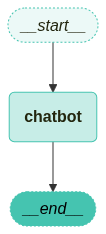

In [8]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

### 챗봇 실행

이제 챗봇과 대화해봅시다!

In [9]:
from langchain_teddynote.messages import stream_graph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

# 질문 입력
user_input = "안녕하세요! LangGraph에 대해 알려주세요."

# Config 설정(recursion_limit: 재귀 깊이 제한, thread_id: 스레드 아이디)
config = RunnableConfig(recursion_limit=20, thread_id="abc123")

In [10]:
inputs = {
    "messages": [HumanMessage(content="안녕하세요! LangGraph에 대해 알려주세요.")]
}

# 그래프 스트리밍
stream_graph(graph, inputs=inputs, config=config)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! LangGraph에 대해 궁금하신 점을 환영합니다. 아래에 LangGraph에 대한 기본적인 설명을 드릴게요.

---

### LangGraph란?

**LangGraph**는 **LangChain** 팀에서 개발한, LLM(대형 언어 모델) 기반 애플리케이션을 **그래프(노드와 엣지로 구성된 구조)** 형태로 설계하고 실행할 수 있게 해주는 오픈소스 프레임워크입니다.

#### 주요 특징

- **상태 기반 워크플로우**: LangGraph는 각 노드가 상태를 받아 처리하고, 다음 노드로 상태를 넘기는 방식으로 동작합니다.
- **분기와 루프**: if/else, 반복 등 복잡한 논리 흐름을 그래프 구조로 쉽게 구현할 수 있습니다.
- **멀티에이전트 시스템**: 여러 LLM 에이전트가 상호작용하는 시스템을 설계할 수 있습니다.
- **LangChain과의 통합**: LangChain의 체인, 에이전트, 툴 등을 그대로 활용할 수 있습니다.
- **Python과 TypeScript 지원**: 두 언어 모두에서 사용할 수 있습니다.

#### 사용 예시

- **챗봇 대화 흐름 설계**
- **문서 요약 및 질의응답 파이프라인**
- **여러 LLM이 협업하는 멀티에이전트 시스템**
- **복잡한 데이터 처리 워크플로우**

#### 간단한 코드 예시 (Python)

```python
from langgraph.graph import StateGraph, END

def node1(state):
    # 상태 처리
    return {"step1": "hello"}

def node2(state):
    # 상태 처리
    return {"step2": state["step1"] + " world"}

graph = StateGraph()
graph.add_node("start", node1)
graph.add_n

---

# Part 2: 도구(Tools) 추가 🔧

챗봇이 "기억"에서 답할 수 없는 질문을 처리하기 위해 웹 검색 도구를 통합합니다. 이를 통해 챗봇이 실시간 정보를 찾아 더 나은 응답을 제공할 수 있습니다.

## 핵심 개념

- **Tool Binding**: LLM에 도구 사용 방법 알려주기
- **Tool Node**: 도구를 실행하는 노드
- **Conditional Edges**: 조건에 따라 다른 노드로 라우팅

In [11]:
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

# Tavily 검색 도구 설정
tool = TavilySearch(max_results=2)
tools = [tool]

# 도구 테스트
result = tool.invoke("LangGraph란 무엇인가요?")
print(f"검색 결과 수: {len(result['results'])}개")
print(f"첫 번째 결과 제목: {result['results'][0]['title']}")

검색 결과 수: 2개
첫 번째 결과 제목: langgraph 소개 및 기본개념 : 네이버 블로그


### 도구를 사용하는 그래프 구성

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# State 정의 (동일)
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 새로운 그래프 빌더 생성
builder = StateGraph(State)

# LLM에 도구 바인딩 - LLM이 도구를 사용할 수 있도록 설정
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    """도구를 사용할 수 있는 챗봇 노드"""
    # 도구가 바인딩된 LLM 호출
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


# 노드 추가
builder.add_node("chatbot", chatbot)

# ToolNode 추가 - 도구를 실행하는 노드
tool_node = ToolNode(tools=tools)
builder.add_node("tools", tool_node)

### 조건부 엣지(Conditional Edges) 추가

챗봇이 도구를 호출해야 할지 직접 응답할지 결정합니다.

### 🔍 tools_condition 함수 상세 설명

`tools_condition`은 LangGraph의 사전 정의된 조건 함수로, LLM의 응답에 도구 호출이 포함되어 있는지 확인합니다.

#### 동작 방식

```python
def tools_condition(state) -> Literal["tools", "__end__"]: 
    """마지막 메시지에 tool_calls가 있는지 확인하여 라우팅을 결정합니다."""
    
    # 1. 상태에서 마지막 메시지 추출
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and "messages" in state:
        ai_message = state["messages"][-1]
    
    # 2. 도구 호출 여부 확인
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 도구 노드로 라우팅
    
    return "__end__"  # 종료
```

#### 핵심 포인트

1. **자동 판단**: LLM이 도구를 호출해야 한다고 판단하면 `tool_calls` 필드가 생성됩니다
2. **조건부 라우팅**: 
   - 도구 호출이 있으면 → `"tools"` 노드로 이동
   - 도구 호출이 없으면 → `"__end__"`로 이동 (그래프 종료)
3. **유연한 상태 처리**: 리스트, 딕셔너리, BaseModel 등 다양한 상태 형식 지원

#### 실제 사용 예시

```python
# LLM이 검색이 필요하다고 판단한 경우
# ai_message.tool_calls = [{"name": "tavily_search", "args": {"query": "..."}}, ...]
# → tools_condition은 "tools"를 반환

# LLM이 직접 답변할 수 있다고 판단한 경우
# ai_message.tool_calls = []
# → tools_condition은 "__end__"를 반환
```

In [13]:
# 조건부 엣지 추가
# tools_condition은 메시지에 tool_calls가 있으면 "tools"로,
# 없으면 END로 라우팅합니다
builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 사전 정의된 조건 함수 사용
)

# 도구 실행 후 다시 챗봇으로 돌아가기
builder.add_edge("tools", "chatbot")

# 시작점 설정
builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph_with_tools = builder.compile()

그래프 시각화

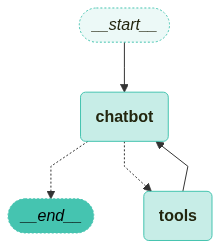

In [14]:
# 그래프 시각화
visualize_graph(graph_with_tools)

### 도구를 사용하는 챗봇 테스트

In [15]:
from langchain_teddynote.messages import stream_graph

stream_graph(
    graph_with_tools,
    inputs={
        "messages": [HumanMessage(content="2025년 LangGraph 사용 사례 알려주세요.")]
    },
    config=config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "2025년 LangGraph 사용 사례", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@sumit.work.connect/langgraph-in-action-trends-use-cases-and-how-to-build-with-it-in-2025-981e8e50dedd", "title": "LangGraph in Action: Trends, Use Cases, and How to build ...", "content": "Published Time: 2025-04-19T14:00:26.497Z\n\nLangGraph in Action: Trends, Use Cases, and How to build with It in 2025 | by Sunny Singh | Medium\n\n===============\n\nSitemap\n\nOpen in app\n\nSign up\n\nSign in\n\n, multi-agent, and loopingworkflows using graph-based computation. Built on NetworkX( a python library used to create, manipulate, and study graphs and networks), it allows each node to do something smart ( like an LLM call or function), while the edges decide where to go next. [...] LangGraph is not just a tool — it’s a mi

---

# Part 3: 메모리 추가 💾

챗봇이 이전 대화 내용을 기억할 수 있도록 **체크포인팅(Checkpointing)** 을 추가합니다. 이를 통해 멀티턴 대화가 가능해집니다.

## 핵심 개념

- **Checkpointer**: 상태를 저장하고 복원하는 메커니즘
- **Thread ID**: 대화 세션을 구분하는 식별자
- **Persistent State**: 여러 호출에 걸쳐 유지되는 상태

In [16]:
from typing import Any
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.store.base import BaseStore
from langchain_openai import ChatOpenAI
from langchain_teddynote.memory import create_memory_extractor
import uuid

model = ChatOpenAI(model="gpt-4.1", temperature=0)
memory_extractor = create_memory_extractor(model="gpt-4.1")


def call_model(
    state: MessagesState,
    config: RunnableConfig,
    *,
    store: BaseStore,
) -> dict[str, Any]:
    """Call the LLM model and manage user memory.

    Args:
        state (MessagesState): The current state containing messages.
        config (RunnableConfig): The runnable configuration.
        store (BaseStore): The memory store.
    """
    # 마지막 메시지에서 user_id 추출
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)

    print(namespace)

    # 유저의 메모리 검색
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([f"{memory.key}: {memory.value}" for memory in memories])
    system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

    # 사용자가 기억 요청 시 메모리 저장
    last_message = state["messages"][-1]
    if "remember" in last_message.content.lower():
        result = memory_extractor.invoke({"input": str(state["messages"][-1].content)})
        for memory in result.memories:
            print(memory)
            print("-" * 100)
            store.put(namespace, str(uuid.uuid4()), {memory.key: memory.value})

    # LLM 호출
    response = model.invoke(
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}

In [17]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

# 그래프 빌드
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

# 메모리 체크포인터 생성
# 실제 프로덕션에서는 PostgresSaver 사용 권장
memory_saver = InMemorySaver()
memory_store = InMemoryStore()

# 그래프 컴파일
graph_with_memory = builder.compile(
    checkpointer=memory_saver,
    store=memory_store,
)

In [18]:
from langchain_teddynote.messages import stream_graph


def run_graph(
    msg,
    thread_id="default",
    user_id="default",
):
    config = {
        "configurable": {
            "thread_id": thread_id + user_id,
            "user_id": user_id,
        }
    }
    print(f"\n[유저🙋] {msg}")
    stream_graph(
        graph_with_memory,
        inputs={"messages": [{"role": "user", "content": msg}]},
        config=config,
    )
    print()

In [19]:
# 메시지, thread_id, user_id 전달
run_graph("안녕? 내 이름은 테디야", "1", "someone")


[유저🙋] 안녕? 내 이름은 테디야
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕, 테디! 만나서 반가워. 오늘은 어떤 도움이 필요해? 😊


In [20]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고?", "1", "someone")


[유저🙋] 내 이름이 뭐라고?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네 이름은 테디라고 했지! 맞지? 😊


In [21]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고?", "2", "someone")


[유저🙋] 내 이름이 뭐라고?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제가 아직 당신의 이름을 알지 못해요. 이름을 알려주시면 앞으로 기억해서 불러드릴 수 있습니다! 이름을 알려주실래요? 😊


`remember` 라는 키워드를 입력하여 Long-term memory에 정보 저장

In [22]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 테디야 remember", "2", "someone")


[유저🙋] 내 이름이 테디야 remember
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{
  "memories": [
    {
      "key": "user_name",
      "value": "테디",
      "category": "personal_info",
      "importance": 5,
      "confidence": 1.0
    }
  ],
  "summary": "사용자는 자신의 이름이 '테디'라고 밝혔음.",
  "timestamp": "2024-06-13T00:00:00Z"
key='user_name' value='테디' category='personal_info' importance=5 confidence=1.0
----------------------------------------------------------------------------------------------------
}알겠어요, 테디! 앞으로 테디라고 불러드릴게요. 궁금한 점이나 도움이 필요하면 언제든 말씀해 주세요! 😊


이렇게 저장한 Long-term memory를 활용할 때는 thread_id 가 바뀌어도 주요 정보를 기억하고 있습니다.

In [23]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고 했더라?", "3", "someone")


[유저🙋] 내 이름이 뭐라고 했더라?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신의 이름은 "테디"라고 하셨어요! 😊


In [24]:
# 메시지, thread_id, user_id 전달
run_graph(
    "내 직업은 AI Engineer 야. 내 취미는 Netflix 보기 야. remember", "4", "someone"
)


[유저🙋] 내 직업은 AI Engineer 야. 내 취미는 Netflix 보기 야. remember
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{
  "memories": [
    {
      "key": "occupation",
      "value": "AI Engineer",
      "category": "personal_info",
      "importance": 5,
      "confidence": 1.0
    },
    {
      "key": "hobby",
      "value": "Netflix 보기",
      "category": "preference",
      "importance": 4,
      "confidence": 1.0
    }
  ],
  "summary": "사용자는 자신의 직업이 AI Engineer이며, 취미는 Netflix 보기라고 밝혔다.",
  "timestamp": "2024-06-14T00:00:00Z"
}key='occupation' value='AI Engineer' category='personal_info' importance=5 confidence=1.0
----------------------------------------------------------------------------------------------------
key='hobby' value='Netflix 보기' category='preference' importance=4 confidence=1.0
----------------------------------------------------------------------------------------------------
알겠어, 테디!  
너의 직업은 AI Engineer이고, 취미는 Netflix 보기인 걸 

In [25]:
# 다른 스레드에서 실행
run_graph("내 이름, 직업, 취미 알려줘", "100", "someone")


[유저🙋] 내 이름, 직업, 취미 알려줘
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 테디님!  
아래는 요청하신 정보입니다:

- 이름: 테디
- 직업: AI Engineer
- 취미: Netflix 보기

다른 궁금한 점 있으시면 언제든 말씀해 주세요! 😊


In [26]:
# 다른 user_id 로 실행한 경우
run_graph("내 이름, 직업, 취미 알려줘", "100", "other")


[유저🙋] 내 이름, 직업, 취미 알려줘
('memories', 'other')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제가 아직 당신의 이름, 직업, 취미에 대한 정보를 받지 못했어요. 알려주시면 기억해서 대화에 반영할 수 있습니다! 알려주실래요? 😊


### State 확인

`get_state` 함수를 사용하여 저장된 상태를 확인할 수 있습니다.

In [27]:
# 임의의 Config 설정
config = {
    "configurable": {
        "thread_id": "100" + "someone",
        "user_id": "someone",
    }
}

# 현재 상태 가져오기
snapshot = graph_with_memory.get_state(config)

print("📊 현재 상태 정보:")
print(f"- 메시지 수: {len(snapshot.values['messages'])}개")
print(f"- 체크포인트 ID: {snapshot.config['configurable']['checkpoint_id']}")

# 최근 메시지 몇 개 표시
print("\n[최근 메시지]")
for msg in snapshot.values["messages"]:
    role = msg.type if hasattr(msg, "type") else "unknown"
    content = msg.content if hasattr(msg, "content") else str(msg)
    print(f"  [{role}]: {content}")

📊 현재 상태 정보:
- 메시지 수: 2개
- 체크포인트 ID: 1f07a5c9-3400-63d8-8001-0aa27fb30ee9

[최근 메시지]
  [human]: 내 이름, 직업, 취미 알려줘
  [ai]: 네, 테디님!  
아래는 요청하신 정보입니다:

- 이름: 테디
- 직업: AI Engineer
- 취미: Netflix 보기

다른 궁금한 점 있으시면 언제든 말씀해 주세요! 😊


---

# Part 4: Human-in-the-Loop 🙋

에이전트가 신뢰할 수 없거나 중요한 결정을 내릴 때 인간의 입력이 필요할 수 있습니다. LangGraph의 **interrupt** 기능을 사용하여 실행을 일시 중지하고 인간의 피드백을 받을 수 있습니다.

## 핵심 개념

- **interrupt**: 실행을 일시 중지하는 함수
- **Command**: 실행을 재개하고 데이터를 전달하는 객체
- **Human Approval**: 인간 검토/승인 프로세스

In [28]:
from langchain_core.tools import tool
from langgraph.types import Command, interrupt


@tool
def human_assistance(query: str) -> str:
    """Request assistance from an expert(human)."""
    # interrupt를 호출하여 실행 일시 중지
    # 사람의 응답을 기다림
    human_response = interrupt({"query": query})

    # 사람의 응답 반환
    return human_response["data"]

### Human-in-the-Loop가 있는 그래프 구성

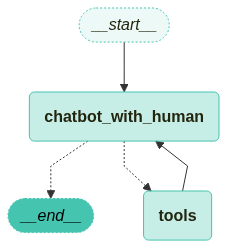

In [29]:
# 도구 리스트 업데이트
tools_with_human = [human_assistance]

# 새로운 그래프 구성
graph_builder_hitl = StateGraph(State)

# LLM에 도구 바인딩
llm_with_human_tools = llm.bind_tools(tools_with_human)


def chatbot_with_human(state: State):
    """Human Interuption 요청할 수 있는 챗봇"""
    message = llm_with_human_tools.invoke(state["messages"])

    # interrupt 중 병렬 도구 호출 방지
    # (재개 시 도구 호출이 반복되는 것을 방지)
    if hasattr(message, "tool_calls"):
        assert (
            len(message.tool_calls) <= 1
        ), "병렬 도구 호출은 interrupt와 함께 사용할 수 없습니다"

    return {"messages": [message]}


# 노드 추가
graph_builder_hitl.add_node("chatbot_with_human", chatbot_with_human)

# ToolNode 추가
tool_node_hitl = ToolNode(tools=tools_with_human)
graph_builder_hitl.add_node("tools", tool_node_hitl)

# 엣지 추가
graph_builder_hitl.add_conditional_edges("chatbot_with_human", tools_condition)
graph_builder_hitl.add_edge("tools", "chatbot_with_human")
graph_builder_hitl.add_edge(START, "chatbot_with_human")

# 메모리와 함께 컴파일
memory_hitl = InMemorySaver()
graph_hitl = graph_builder_hitl.compile(checkpointer=memory_hitl)

# 그래프 시각화
visualize_graph(graph_hitl)

### Human-in-the-Loop 테스트

In [30]:
from langchain_teddynote.messages import random_uuid

# 인간 지원을 요청하는 메시지
user_input = "LangGraph 잘하고 싶은데, 사람에게 조언을 듣고 싶어요."
config_hitl = {"configurable": {"thread_id": random_uuid()}}

print(f"User: {user_input}\n")

stream_graph(
    graph_hitl,
    inputs={"messages": [HumanMessage(content=user_input)]},
    config=config_hitl,
)

User: LangGraph 잘하고 싶은데, 사람에게 조언을 듣고 싶어요.


🔄 Node: chatbot_with_human 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [31]:
# 상태 확인 - 어느 노드에서 중단되었는지 확인
snapshot = graph_hitl.get_state(config_hitl)
print(f"\n📊 현재 상태:")
print(f"  다음 실행할 노드: {snapshot.next}")
print(f"  체크포인트 ID: {snapshot.config['configurable']['checkpoint_id']}")


📊 현재 상태:
  다음 실행할 노드: ('tools',)
  체크포인트 ID: 1f07a5c9-480c-6e4e-8001-21228b57b1c9


In [32]:
# 인간의 응답으로 실행 재개
human_response = """## 전문가의 조언: 
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)
"""

# Command 객체로 재개
human_command = Command(resume={"data": human_response})

print(f"\n💡 사람의 응답: {human_response}\n")

# 재개
stream_graph(graph_hitl, inputs=human_command, config=config_hitl)


💡 사람의 응답: ## 전문가의 조언: 
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)



🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
## 전문가의 조언: 
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)

🔄 Node: chatbot_with_human 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
LangGraph를 잘하고 싶으시다면, 다음과 같은 전문가의 조언을 참고해보세요:

1. YouTube 테디노트 채널: LangGraph와 관련된 다양한 실습과 설명 영상이 많아 초보자부터 중급자까지 도움이 됩니다.
   - https://www.youtube.com/c/teddynote

2. 패스트캠퍼스 RAG 비법노트 강의: 실제 현업 개발자가 알려주는 실전 강의로, LangGraph와 RAG(검색 증강 생성) 기술을 깊이 있게 배울 수 있습니다.
   - https://fastcampus.co.kr/data_online_teddy

이 자료들을 참고해서 실습과 프로젝트를 병행해보시면 실력이 빠르게 늘어날 거예요! 궁금한 점이 있으면 언제든 질문해 주세요.

---

# Part 5: 상태 커스터마이징 🎨

메시지 리스트 외에 추가 필드를 상태에 추가하여 복잡한 동작을 정의할 수 있습니다. 예를 들어, 특정 정보를 저장하고 인간의 검토를 받는 워크플로우를 구현해봅시다.

## 핵심 개념

- **Custom State Fields**: 상태에 커스텀 필드 추가
- **State Updates from Tools**: 도구 내부에서 상태 업데이트
- **Manual State Updates**: 수동으로 상태 변경

In [33]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId


# 확장된 State 정의
class CustomState(TypedDict):
    """커스텀 필드가 추가된 상태"""

    messages: Annotated[list, add_messages]
    human_feedback: str  # 사람의 피드백

### 상태를 업데이트하는 도구

In [34]:
@tool
def human_review(
    human_feedback, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request human review for information."""
    # 인간에게 검토 요청
    human_response = interrupt(
        {"question": "이 정보가 맞나요?", "human_feedback": human_feedback}
    )

    feedback = human_response.get("human_feedback", "")

    if feedback.strip() == "":
        # 사용자가 AI 의 답변에 동의하는 경우
        return Command(
            update={
                "messages": [ToolMessage(human_response, tool_call_id=tool_call_id)]
            }
        )
    else:
        # 사용자가 AI 의 답변에 동의하지 않는 경우
        corrected_information = f"# 사용자에 의해 수정된 피드백: {feedback}"
        return Command(
            update={
                "messages": [
                    ToolMessage(corrected_information, tool_call_id=tool_call_id)
                ]
            }
        )

### 커스텀 상태를 사용하는 그래프

In [35]:
# 도구 리스트
tools_custom = [human_review]

# 새로운 그래프 구성
custom_graph_builder = StateGraph(CustomState)  # CustomState 사용

# LLM에 도구 바인딩
llm_with_custom_tools = llm.bind_tools(tools_custom)


def chatbot_custom(state: CustomState):
    """커스텀 상태를 사용하는 챗봇"""
    message = llm_with_custom_tools.invoke(state["messages"])

    if hasattr(message, "tool_calls"):
        assert len(message.tool_calls) <= 1

    return {"messages": [message]}


# 노드와 엣지 추가
custom_graph_builder.add_node("chatbot", chatbot_custom)
tool_node_custom = ToolNode(tools=tools_custom)
custom_graph_builder.add_node("tools", tool_node_custom)

custom_graph_builder.add_conditional_edges("chatbot", tools_condition)
custom_graph_builder.add_edge("tools", "chatbot")
custom_graph_builder.add_edge(START, "chatbot")

# 컴파일
memory_custom = InMemorySaver()
custom_graph = custom_graph_builder.compile(checkpointer=memory_custom)

그래프를 시각화 합니다.

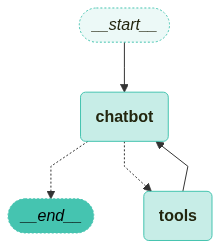

In [36]:
# 그래프 시각화
visualize_graph(custom_graph)

### 커스텀 상태 테스트

In [37]:
# LangGraph의 출시일을 조사하고 검토 요청
user_input = (
    "2024년 노벨 문학상 수상자가 누구인지 조사해주세요. "
    "답을 찾으면 `human_review` 도구를 사용해서 검토를 요청하세요."
)

custom_config = RunnableConfig(configurable={"thread_id": random_uuid()})

print(f"User: {user_input}\n")

# 실행 (interrupt에서 중단될 것임)
stream_graph(
    custom_graph,
    inputs={"messages": [HumanMessage(content=user_input)]},
    config=custom_config,
)

User: 2024년 노벨 문학상 수상자가 누구인지 조사해주세요. 답을 찾으면 `human_review` 도구를 사용해서 검토를 요청하세요.


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [38]:
from langchain_teddynote.messages import display_message_tree

# 최신 메시지 가져오기
last_message = custom_graph.get_state(custom_config).values["messages"][-1]

# 최신 메시지 tree 구조로 표시
display_message_tree(last_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_NiOU1FwqNErEkmrgiavl332n"
                function: {"arguments": "{"human_feedback":"2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다."}", "name": "human_review"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_daf5fcc80a", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--74d9003c-0d93-45ac-8aab-70572c0eccd5"
    example: False
    tool_calls:
        index [0]
            name: "human_review"
            args: {"human_feedback": "2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다."}
            id: "call_NiOU1FwqNErEkmrgiavl332n"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: None


In [39]:
# AI 가 작성한 내용
print(last_message.tool_calls[0]["args"]["human_feedback"])

2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다.


In [40]:
# 인간의 검토 응답으로 재개
human_command = Command(
    resume={"human_feedback": "2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다."}
)

stream_graph(custom_graph, inputs=human_command, config=custom_config)


🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
# 사용자에 의해 수정된 피드백: 2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다.
🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다. (이 정보는 사용자에 의해 검토 및 수정되었습니다.)

---

# Part 6: 타임 트래블 ⏰

LangGraph의 **타임 트래블** 기능을 사용하면 이전 체크포인트로 돌아가서 다른 경로를 탐색할 수 있습니다. 이는 디버깅, 실험, 대화형 애플리케이션에 매우 유용합니다.

## 핵심 개념

- **State History**: 모든 체크포인트의 기록
- **Checkpoint ID**: 특정 시점의 식별자
- **Rewind**: 이전 상태로 되돌리기
- **Resume**: 특정 체크포인트에서 재개

### 타임 트래블을 위한 그래프 준비

In [53]:
# 타임 트래블 테스트를 위한 간단한 그래프
graph_builder = StateGraph(State)

# 도구와 LLM 설정
tools = [TavilySearch(max_results=2)]
llm_with_tools_tt = llm.bind_tools(tools)


def chatbot_tt(state: State):
    """타임 트래블 테스트용 챗봇"""
    return {"messages": [llm_with_tools_tt.invoke(state["messages"])]}


# 그래프 구성
graph_builder.add_node("chatbot", chatbot_tt)
tool_node_tt = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node_tt)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 메모리와 함께 컴파일
memory_tt = InMemorySaver()
time_travel_graph = graph_builder.compile(checkpointer=memory_tt)

시각화를 수행합니다.

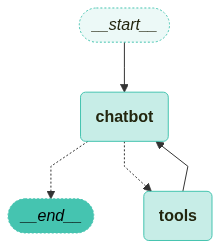

In [54]:
# 시각화
visualize_graph(time_travel_graph)

### 여러 단계의 대화 생성

In [55]:
time_travel_config = RunnableConfig(configurable={"thread_id": "time-travel-1"})

# 첫 번째 대화
stream_graph(
    time_travel_graph,
    inputs={"messages": [HumanMessage(content="테디노트에 대해서 조사 좀 해주세요.")]},
    config=time_travel_config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "테디노트란 무엇인가", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://teddylee777.github.io/", "title": "테디노트", "content": "테디노트 Skip to primary navigation Skip to content Skip to footer 테디노트 데이터와 인공지능을 좋아하는 개발자 노트 poetry 의 거의 모든것 (튜토리얼) 지금부터 poetry 활용 튜토리얼을 살펴 보겠습니다. LangGraph Retrieval Agent는 언어 처리, AI 모델 통합, 데이터베이스 관리, 그래프 기반 데이터 처리 등 다양한 기능을 제공하여 언어 기반 AI 애플리케이션 개발에 필수적인 도구입니다. 본 튜토리얼은 OpenAI Assistants API를 활용하는 내용을 다룹니다. [LangChain] 에이전트(Agent)와 도구(tools)를 활용한 지능형 검색 시스템 구축 가이드 이 글에서는 LangChain 의 Agent 프레임워크를 활용하여 복잡한 검색과 데이터 처리 작업을 수행하는 방법을 소개합니다. LangChain을 활용하여 간단하게 네이버 뉴스기사를 바탕으로 Q&A 애플리케이션을 만드는 방법을 다룹니다. LangChain Expression Language(LCEL) 원리 이해와 파이프라인 구축 가이드 이 블로그 글에서는 LangChain Expression Language(LCEL) 원리 이해와 LCEL 에 기반한 파이프라인 구축의 기본을 소개합니다. © 2024 테디노트.", "score": 0.5968332, "raw_content": null}

In [56]:
# 두 번째 대화
stream_graph(
    time_travel_graph,
    inputs={
        "messages": [
            HumanMessage(content="테디노트 온라인 강의 주소를 조사해 해주세요.")
        ]
    },
    config=time_travel_config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "테디노트 온라인 강의 주소", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://wikidocs.net/book/16865", "title": "테디노트의 RAG 비법노트 : RAG 시작하기 - WikiDocs - 위키독스", "content": "4.    본 저작물은 개인 학습 및 비상업적 목적으로만 이용하여야 하며, 본 저작물을 강의, 강연 등 상업적 목적으로 활용하고자 하는 경우, 저작권자와의 사전 서면 협의가 필수적으로 요구됩니다. 해당 협의는 help@fastcampus.co.kr으로 문의하여 진행하실 수 있습니다.\n\n주식회사 데이원컴퍼니는 저작권을 적극 보호하며, 위반 시 법적 책임을 물을 수 있습니다.\n```\n\n최근 수정글 (10))RSS\n\nRAG 시작하기(LangChain 랭체인 비법노트) - 2025년 3월 18일 1:07 오후 \n\n이 책의 내용은 패스트캠퍼스의 온라인 강의 < 테디노트의 RAG 비법노트 : 랭체인을 활용한 GPT부터 로컬 모델까지의 RAG 가이드 > 중 …\n\n[08. [프로젝트] 더 나은 답변을 위한 프롬프트 조정하기(출처, 표)]( - 2024년 11월 4일 9:44 오후 [...] 위키독스의 < RAG 비법노트 : RAG 시작하기 > 는 패스트캠퍼스의 온라인 강의 < 테디노트의 RAG 비법노트 : 랭체인을 활용한 GPT부터 로컬 모델까지의 RAG 가이드 > 중 챕터 3의 내용을 무료 공개하고 있습니다. RAG에 대한 고급 내용이나 다양한 실습 프로젝트는 유료 온라인 강의에서만 확인할 수 있습니다. \n\n🔽 RAG 강의 바로가기 (이미

### 상태 히스토리 탐색

In [57]:
# 전체 상태 히스토리 확인
print("📜 상태 히스토리 (최신순):")
print("=" * 80)

# to_replay 변수 초기화
to_replay = None

for i, state in enumerate(time_travel_graph.get_state_history(time_travel_config)):
    print(f"\n[체크포인트 {i}]")
    print(f"  다음 노드: {state.next}")
    print(f"  체크포인트 ID: {state.config['configurable']['checkpoint_id']}")

    if len(state.values["messages"]) == 6 and to_replay is None:
        print("  ⭐ 이 상태로 되돌아갈 예정")
        display_message_tree(state.values["messages"][-1])
        to_replay = state


print("\n" + "=" * 80)

📜 상태 히스토리 (최신순):

[체크포인트 0]
  다음 노드: ()
  체크포인트 ID: 1f07a5eb-e330-637c-8008-71671e1c4d7b

[체크포인트 1]
  다음 노드: ('chatbot',)
  체크포인트 ID: 1f07a5eb-d0be-60a4-8007-821c53f1220d

[체크포인트 2]
  다음 노드: ('tools',)
  체크포인트 ID: 1f07a5eb-bfea-6fde-8006-d5bf2a5ad5b0
  ⭐ 이 상태로 되돌아갈 예정
    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
                function: {"arguments": "{"query":"테디노트 온라인 강의 주소","search_depth":"advanced"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_daf5fcc80a", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--6b7ef423-f326-49b8-96c9-eaf5f8fc446f"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소", "search_depth": "advanced"}
            id: "ca

### 특정 체크포인트에서 재개

In [58]:
display_message_tree(to_replay.values["messages"][-1])

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
                function: {"arguments": "{"query":"테디노트 온라인 강의 주소","search_depth":"advanced"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_daf5fcc80a", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--6b7ef423-f326-49b8-96c9-eaf5f8fc446f"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소", "search_depth": "advanced"}
            id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: None


`update_tool_call` 을 활용하여 검색할 쿼리를 수정합니다.

In [61]:
from langchain_teddynote.tools import update_tool_call

# 사용 예시:
updated_message = update_tool_call(
    to_replay.values["messages"][-1],
    tool_name="tavily_search",
    tool_args={"query": "테디노트 강의 site:fastcampus.co.kr", "search_depth": "basic"},
)

In [ ]:
# 변경하기 전의 message
display_message_tree(to_replay.values["messages"][-1])

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
                function: {"arguments": "{"query": "테디노트 강의 site:fastcampus.co.kr", "search_depth": "basic"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_daf5fcc80a", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--6b7ef423-f326-49b8-96c9-eaf5f8fc446f"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소", "search_depth": "advanced"}
            id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: None


In [ ]:
# 변경한 이후의 메시지 트리
display_message_tree(updated_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
                function: {"arguments": "{"query": "테디노트 강의 site:fastcampus.co.kr", "search_depth": "basic"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_daf5fcc80a", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--6b7ef423-f326-49b8-96c9-eaf5f8fc446f"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 강의 site:fastcampus.co.kr", "search_depth": "basic"}
            id: "call_wFNqW9j0jw4BZoSv15tiOhfv"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: None


In [ ]:
# 변경된 메시지를 update_state 로 업데이트
updated_state = time_travel_graph.update_state(
    values={"messages": [updated_message]}, config=to_replay.config
)

업데이트된 메시지를 스트리밍 합니다. 여기서 `inputs` 는 `None` 으로 주고, `config` 는 `updated_state` 로 주어 Replay 합니다.

In [ ]:
# 업데이트된 메시지를 스트리밍 합니다.
stream_graph(time_travel_graph, inputs=None, config=updated_state)


🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "테디노트 강의 site:fastcampus.co.kr", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fastcampus.co.kr/data_online_teddylive", "title": "[Live] 테디노트의 월간 AI 핸즈온 : 테디클럽 - 패스트캠퍼스", "content": "\\* 본 상품은 동영상 형태의 강의를 수강하는 상품이며, 실시간 라이브는 자율적으로 참여 하실 수 있습니다. \\* 라이브는 25년 7월부터 26년 6월까지 매월 마지막주 진행 예정이나, 정확한 일정은 당사 사정에 따라 변경될 수 있습니다. 본 패키지는 약 **70**시간 분량으로, 일 1시간 내외의 학습 시간을 통해 정상 수강 기간(=유료 수강 기간) 내에 모두 수강이 가능합니다. 수강시작 후 7일 이내, 5강 미만 수강 시에는 100% 환불 가능합니다. 수강시작 후 7일 이내, 5강 이상 수강 시 전체 강의에서 수강한 강의의 비율에 해당하는 수강료를 차감 후 환불 가능합니다. 수강시작 후 7일 초과 시 **정상 수강기간 \"90일\" 대비** 잔여일에 대해 아래 환불규정에 따라 환불 가능합니다. 패스트캠퍼스 온라인 강의 시청을 위해서는 ID별 최대 4개의 기기를 등록할 수 있으며, 기기 등록은 온라인 강의장 접속 시 자동 등록됩니다.", "score": 0.68344116, "raw_content": null}, {"url": "https://fastcampus.co.kr/category_online_aitechrag", "title": "커리어 성장을 위한 최고의 실무교육 아카데미 - 패스트캠퍼스", "content": "[Live] 테디노트의 월간 AI 핸즈온 : 테디클럽. 기간한정약 70시간누구나. 50 ... 강의 